In [1]:
# numpy and pandas for data manipulation
import sys
# Suppress warnings
import warnings

import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd

warnings.filterwarnings('ignore')

# matplotlib and seaborn for plotting
import matplotlib.pyplot as plt
%matplotlib inline

ROOT_PACKAGE_DIRECTORY = '/Users/bede01/Documents/work/phd-papers/ml-workload-optimization/code/jupyter'
root_data = ROOT_PACKAGE_DIRECTORY + '/data'


sys.path.append(ROOT_PACKAGE_DIRECTORY)
from experiment_graph.execution_environment import ExecutionEnvironment

## Use Case 1
Here are the steps for the use case 1
1. Load data
2. chain 2 data transformation and a model training
3. store the graph
4. open a new workload
5. load the history graph
6. write the exact same transformations and model training
7. the model should be fetched from the history graph instead being executed

In [2]:
DATABASE_PATH = root_data + '/experiment_graphs/optimizer_test/uc1'

In [3]:
# Simple Case: Chain of 4 operations

# Create Execution Environment
ee = ExecutionEnvironment('dedup')
# Load Data
train = ee.load(root_data + '/openml/task_id=31/train.csv')

# Transformation 1
train = train.drop(columns=['checking_status'])

# Transformation 2
train = train.drop(columns=['class'])

# Transformation 3
max_cols = train.max()

# Execute
data_main = max_cols.data(verbose = 1)

# Save history graph
ee.save_history(DATABASE_PATH, overwrite=True)
# Plot workload graph
ee.workload_graph.plot_graph(plt, edge_oper=True)


######### NEW WORKLOAD ############

# Create new environment
ee_2 = ExecutionEnvironment('dedup')
# Load the history graph
ee_2.load_history(DATABASE_PATH)
# Simple Case: Chain of 4 operations

# Load Data
train = ee.load(root_data + '/openml/task_id=31/train.csv')

# Transformation 1
train = train.drop(columns=['checking_status'])

# Transformation 2
train = train.drop(columns=['class'])

# Transformation 3
max_cols = train.max()

# Execute
data_second_workload = max_cols.data(verbose = 1)

size of the optimized graph = 4
104E86B0 False
/Users/bede01/Documents/work/phd-papers/ml-workload-optimization/code/jupyter/data/openml/task_id=31/train.csv False
C79F871F False
EDEEED83 False
/Users/bede01/Documents/work/phd-papers/ml-workload-optimization/code/jupyter/data/openml/task_id=31/train.csv--drop({'columns':['checking_status']})->C79F871F
size of the optimized graph = 1
104E86B0 False
/Users/bede01/Documents/work/phd-papers/ml-workload-optimization/code/jupyter/data/openml/task_id=31/train.csv False
C79F871F False
EDEEED83 False
C79F871F--drop({'columns':['class']})->104E86B0
104E86B0--max(None)->EDEEED83


TypeError: p_max() argument after ** must be a mapping, not NoneType

size of the optimized graph = 6
5772E6E6 False
0A40240F False
79F98C6F False
538AE25A False
0A40240F79F98C6F False
/Users/bede01/Documents/work/phd-papers/ml-workload-optimization/code/jupyter/data/openml/task_id=31/train.csv False
/Users/bede01/Documents/work/phd-papers/ml-workload-optimization/code/jupyter/data/openml/task_id=31/train.csv--drop({'columns':['checking_status']})->538AE25A
size of the optimized graph = 1
5772E6E6 False
0A40240F False
79F98C6F False
538AE25A False
0A40240F79F98C6F False
/Users/bede01/Documents/work/phd-papers/ml-workload-optimization/code/jupyter/data/openml/task_id=31/train.csv False
538AE25A--drop({'columns':['class']})->79F98C6F
79F98C6F--fit_sk_model({'model':MinMaxScaler(copy=True,feature_range=(0,1))})->0A40240F
0A40240F--combine({})->0A40240F79F98C6F
79F98C6F--combine({})->0A40240F79F98C6F
0A40240F79F98C6F--transform({})->5772E6E6


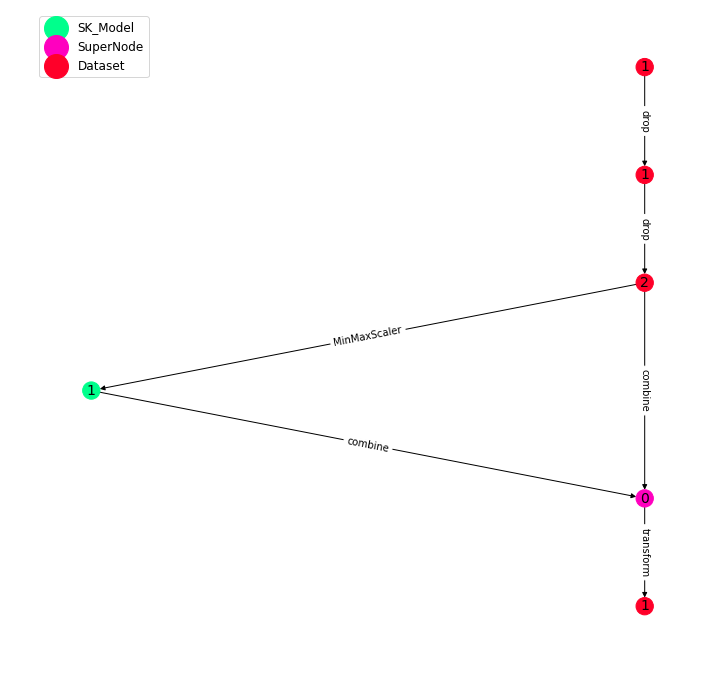

In [5]:
# With Combine

# Create Execution Environment
ee = ExecutionEnvironment('dedup')
# Load Data
train = ee.load(root_data + '/openml/task_id=31/train.csv')

# Transformation 1
train = train.drop(columns=['checking_status'])

# Transformation 2
train = train.drop(columns=['class'])

# Transformation 3: Combine
from experiment_graph.sklearn_helper.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
scaler.fit(train)
train = scaler.transform(train)
data_main = train.data(verbose = 1)

# Save and Print
ee.save_history(DATABASE_PATH, overwrite=True)
ee.workload_graph.plot_graph(plt, edge_oper=True)

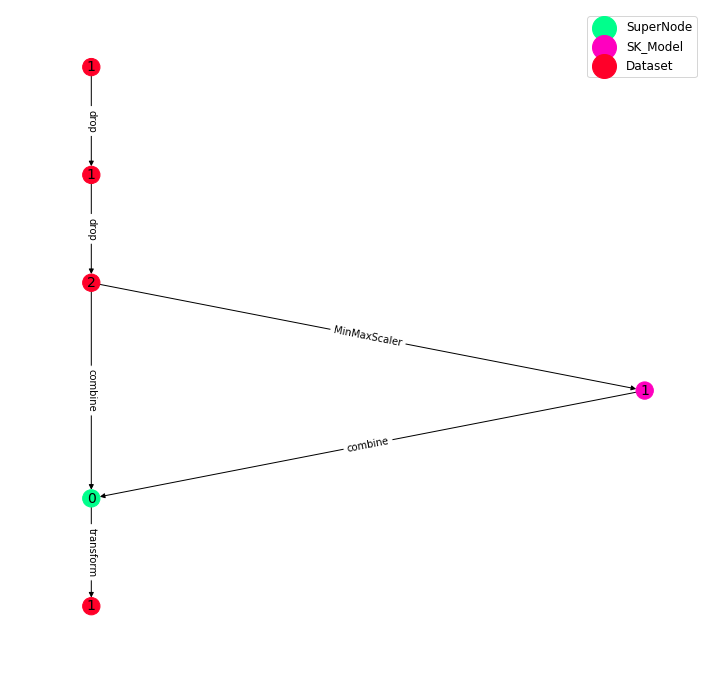

In [5]:
ee_2 = ExecutionEnvironment('dedup')
ee_2.load_history(DATABASE_PATH)
# With Combine
# Load Data
train = ee_2.load(root_data + '/openml/task_id=31/train.csv')

# Transformation 1
train = train.drop(columns=['checking_status'])

# Transformation 2
train = train.drop(columns=['class'])

# Transformation 3: Combine
from experiment_graph.sklearn_helper.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
scaler.fit(train)
train = scaler.transform(train)
data_from_workload = train.data(verbose = 1)

In [6]:
ee_2 = ExecutionEnvironment('dedup')
ee_2.load_history(DATABASE_PATH)

In [7]:
# Load Data
train = ee_2.load(root_data + '/openml/task_id=31/train.csv')

# Transformation 1
train = train.drop(columns=['checking_status'])

# Transformation 2
#train_labels = train['class']
train = train.drop(columns=['class'])

# Transformation 3
from experiment_graph.sklearn_helper.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
scaler.fit(train)
train = scaler.transform(train)
data = train.data(verbose=1)

# Model Training
# from experiment_graph.sklearn_helper.ensemble import RandomForestClassifier
# random_forest = RandomForestClassifier(n_estimators=10, random_state=50, verbose=1, n_jobs=-1)
# random_forest.fit(train, train_labels)

# # Execute
# random_forest.trained_node.data(verbose=1)

materialized nodes = {'/Users/bede01/Documents/work/phd-papers/ml-workload-optimization/code/jupyter/data/openml/task_id=31/train.csv': '/Users/bede01/Documents/work/phd-papers/ml-workload-optimization/code/jupyter/data/openml/task_id=31/train.csv', 'BB1427F0': 'FD6CBFF9', 'A6344BB2': '0E6852A0', 'CDCB5C78': 'C8A0CEE0'}
size of the optimized graph = 4
A6344BB2 True
BB1427F0 True
/Users/bede01/Documents/work/phd-papers/ml-workload-optimization/code/jupyter/data/openml/task_id=31/train.csv True
CDCB5C78 True
B5AD0651 False
CDCB5C78BB1427F0 False
BB1427F0--fit_sk_model({'model':MinMaxScaler(copy=True,feature_range=(0,1))})->CDCB5C78
CDCB5C78--combine({})->CDCB5C78BB1427F0
BB1427F0--combine({})->CDCB5C78BB1427F0
CDCB5C78BB1427F0--transform({})->B5AD0651


In [8]:
ee_2.workload_graph.graph.nodes(data=True)

NodeDataView({'2B30EF94': {'root': False, 'size': 0.13176727294921875, 'type': 'Dataset', 'data': <experiment_graph.execution_environment.Dataset object at 0x10d6a7b10>}, '51E51A5D8D090677': {'type': 'SuperNode', 'size': 0.0, 'root': False, 'data': <experiment_graph.execution_environment.SuperNode object at 0x10d68a790>}, '51E51A5D': {'root': False, 'size': 0.13176727294921875, 'type': 'Dataset', 'data': <experiment_graph.execution_environment.Dataset object at 0x1054e80d0>}, '7B6AA8DB2B30EF94': {'type': 'SuperNode', 'size': 0.0, 'root': False, 'data': <experiment_graph.execution_environment.SuperNode object at 0x10d6a7bd0>}, '7B6AA8DB': {'root': False, 'size': 6.103515625e-05, 'type': 'SK_Model', 'data': <experiment_graph.execution_environment.SK_Model object at 0x10d2372d0>}, '96C4A8A0': {'root': False, 'size': 0.138702392578125, 'type': 'Dataset', 'data': <experiment_graph.execution_environment.Dataset object at 0x10d428490>}, '/Users/bede01/Documents/work/phd-papers/ml-workload-opt

In [9]:
a = 2

In [10]:
a = 1 if a is None else a

In [11]:
a

2